In [5]:
# imports

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint


## 1.1.1:

In [39]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JNJ', 'JPM', 'V', 'PG', 'UNH', 'HD']
start_date = '2003-03-25'
end_date = '2023-03-25'
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)

adj_close_data = data['Close']
log_returns = np.log(adj_close_data / adj_close_data.shift(1)).dropna()

weekly_log_returns = log_returns.diff(5).dropna()
monthly_log_returns = log_returns.diff(21).dropna()
yearly_log_returns = log_returns.diff(252).dropna()

autocorr_results = pd.DataFrame(index=tickers, columns=['Daily', 'Weekly', 'Monthly', 'Yearly'])
for ticker in tickers:
    autocorr_results.loc[ticker, 'Daily'] = log_returns[ticker].autocorr(lag=1)
    autocorr_results.loc[ticker, 'Weekly'] = weekly_log_returns[ticker].autocorr(lag=1)
    autocorr_results.loc[ticker, 'Monthly'] = monthly_log_returns[ticker].autocorr(lag=1)
    autocorr_results.loc[ticker, 'Yearly'] = yearly_log_returns[ticker].autocorr(lag=1)

print("Autocorrelation of returns:")
print(autocorr_results)


[*********************100%***********************]  10 of 10 completed

Autocorrelation of returns:
          Daily    Weekly   Monthly    Yearly
AAPL  -0.046209 -0.048335  -0.02162  -0.03599
MSFT  -0.114809 -0.075114  -0.10282 -0.087885
GOOGL -0.048517 -0.018133 -0.023217 -0.044397
AMZN   -0.01998 -0.014221 -0.022631  0.023574
JNJ   -0.091518 -0.068625 -0.093675 -0.064901
JPM   -0.107508 -0.059291 -0.147205 -0.131238
V     -0.109409 -0.058531  -0.11503 -0.103902
PG    -0.092274 -0.046279 -0.092847  -0.09515
UNH   -0.064148 -0.014071 -0.036957 -0.074388
HD    -0.034876  0.006145 -0.045803 -0.049738


## 1.1.2:

Based on the lag‑1 autocorrelation values for log returns at different frequencies (daily, weekly, monthly, and yearly):

Daily Returns: Most stocks show mildly negative autocorrelations (around –0.03 to –0.11), suggesting that a positive return today is often followed by a lower or negative return the next day. This is a sign of short‑term mean reversion rather than momentum.

Weekly and Monthly Returns: The weekly values remain negative but tend to be slightly less extreme. Monthly returns still show a mild negative autocorrelation, meaning that while the reversal effect is present, any trend may persist a bit longer before the mean reversion kicks in.

Yearly Returns: The negative autocorrelation mostly continues over the yearly horizon. An exception is AMZN, which has a small positive yearly autocorrelation; this might indicate a weak momentum effect over the long term for that stock.

Overall, these findings indicate that for this group of stocks, short‑term movements tend to reverse, but the signal is less clear over longer periods.

## 1.1.3:

Based on the lag‑1 autocorrelations, we see that daily returns have a fairly strong immediate reversal (with values ranging from about –0.03 to –0.11), whereas the monthly series show very mild negative autocorrelation (often around –0.02 to –0.04). In practical terms, this means that if you were to look at the full autocorrelation function (i.e. across multiple lags), the monthly returns would likely sustain a momentum‐like signal (or at least a weaker reversal) over more lags before the negative (reversal) effect fully kicks in. In contrast, the daily series reverse almost immediately.

Thus, the monthly period appears to have the longest “memory” before the reversal dominates—suggesting that trends (or at least less negative serial correlation) persist longer on a monthly scale than on daily or weekly scales.

--Daily returns reverse very quickly (a positive return is often immediately offset by a negative one the next day), while monthly returns maintain their trend a bit longer. In other words, the “memory” of returns is longer on a monthly basis than on a daily or weekly basis, which suggests that if any momentum exists, it may be more detectable on a monthly scale.

## 2.1/2.2:

In [40]:
start_date = '2013-01-01'
end_date = '2022-12-31'
lookback = 12
top_frac = 0.20
bottom_frac = 0.20

tickers2 = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JNJ', 'JPM', 'V', 'PG', 'UNH', 'HD']

price_data = yf.download(tickers2, start=start_date, end=end_date, auto_adjust=True)['Close']
monthly_prices = price_data.resample('M').last()
monthly_returns = monthly_prices.pct_change()
strategyA_ret = []
strategyB_ret = []
dates = monthly_prices.index

for t in range(lookback + 1, len(dates)):
    formation_returns = monthly_prices.iloc[t - lookback - 1 : t - 1].pct_change().add(1).prod() - 1
    ranked = formation_returns.sort_values(ascending=False)
    n = len(ranked)
    top_n = int(np.floor(top_frac * n))
    bottom_n = int(np.floor(bottom_frac * n))
    long_positions = ranked.index[:top_n]

    ret_A = monthly_returns.iloc[t][long_positions].mean()
    long_ret = monthly_returns.iloc[t][ranked.index[:top_n]].mean()
    short_ret = monthly_returns.iloc[t][ranked.index[-bottom_n:]].mean()
    ret_B = long_ret - short_ret

    strategyA_ret.append(ret_A)
    strategyB_ret.append(ret_B)

dates_strategy = dates[lookback + 1:]
stratA = pd.Series(strategyA_ret, index=dates_strategy)
stratB = pd.Series(strategyB_ret, index=dates_strategy)
benchmark = yf.download('SPY', start=start_date, end=end_date, auto_adjust=True)['Close'].resample('M').last().pct_change().dropna()

def performance_metrics(returns, annualize_factor=12):
    cum_return = (1 + returns).prod() - 1
    ann_ret = returns.mean() * annualize_factor
    ann_vol = returns.std() * np.sqrt(annualize_factor)
    sharpe = np.where(ann_vol != 0, ann_ret / ann_vol, np.nan)
    equity_curve = (1 + returns).cumprod()
    drawdown = (equity_curve / equity_curve.cummax() - 1).min()
    avg_win = returns[returns > 0].mean() if returns[returns > 0].shape[0] > 0 else np.nan
    avg_loss = returns[returns < 0].mean() if returns[returns < 0].shape[0] > 0 else np.nan
    return cum_return, sharpe, drawdown, avg_win, avg_loss

perf_A = performance_metrics(stratA)
perf_B = performance_metrics(stratB)
perf_BH = performance_metrics(benchmark)

print("Strategy A (Long Only Winners):")
print("Cumulative 10-year Return:", perf_A[0])
print("Sharpe Ratio:", perf_A[1])
print("Max Drawdown:", perf_A[2])
print("Average Win:", perf_A[3])
print("Average Loss:", perf_A[4])
print()
print("Strategy B (Long-Short Momentum):")
print("Cumulative 10-year Return:", perf_B[0])
print("Sharpe Ratio:", perf_B[1])
print("Max Drawdown:", perf_B[2])
print("Average Win:", perf_B[3])
print("Average Loss:", perf_B[4])
print()
print("Buy-and-Hold (SPY):")
print("Cumulative 10-year Return:", perf_BH[0])
print("Sharpe Ratio:", perf_BH[1])
print("Max Drawdown:", perf_BH[2])
print("Average Win:", perf_BH[3])
print("Average Loss:", perf_BH[4])



[*********************100%***********************]  10 of 10 completed
/var/folders/kl/99r23_5x5x5ggl9nb8wl5wtc0000gn/T/ipykernel_62391/851404200.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = price_data.resample('M').last()
[*********************100%***********************]  1 of 1 completed
/var/folders/kl/99r23_5x5x5ggl9nb8wl5wtc0000gn/T/ipykernel_62391/851404200.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  benchmark = yf.download('SPY', start=start_date, end=end_date, auto_adjust=True)['Close'].resample('M').last().pct_change().dropna()


Strategy A (Long Only Winners):
Cumulative 10-year Return: 4.893687000301241
Sharpe Ratio: 1.0859554009030787
Max Drawdown: -0.41047547859026023
Average Win: 0.052934719727840626
Average Loss: -0.044251451598552746

Strategy B (Long-Short Momentum):
Cumulative 10-year Return: -0.4423059154427863
Sharpe Ratio: -0.1994511537640528
Max Drawdown: -0.523792261438354
Average Win: 0.04500342125795455
Average Loss: -0.047754629462242175

Buy-and-Hold (SPY):
Cumulative 10-year Return: Ticker
SPY    2.075896
dtype: float64
Sharpe Ratio: [0.84499276]
Max Drawdown: Ticker
SPY   -0.239272
dtype: float64
Average Win: Ticker
SPY    0.032032
dtype: float64
Average Loss: Ticker
SPY   -0.039504
dtype: float64


## 2.3.3:
Strategy A (Long Only Winners) vs. Buy-and-Hold (SPY):
Strategy A delivers a dramatically higher cumulative return (489.4% vs. 207.6%) and a better risk-adjusted performance (Sharpe 1.09 vs. 0.84) than SPY. However, this outperformance comes with higher volatility, as seen in its deeper maximum drawdown (-41.0% compared to -23.9%) and larger swings in average monthly wins and losses.

Strategy B (Long-Short Momentum) vs. Buy-and-Hold (SPY):
Strategy B underperforms significantly, with a negative cumulative return (-44.2%) and a negative Sharpe ratio (-0.20), whereas SPY posted solid gains (207.6% cumulative return) and a positive Sharpe (0.84). Additionally, its maximum drawdown is considerably worse (-52.4% vs. -23.9%), indicating that the long-short approach in this narrow universe did not effectively capture momentum benefits.

## 2.3:

We chose the Long Only Winners momentum strategy because it significantly outperformed buy-and‑hold in both cumulative returns and risk-adjusted returns. Over 10 years, it achieved a 489.4% cumulative return with a Sharpe ratio of 1.09—far higher than SPY’s 207.6% return and Sharpe ratio of 0.84—even though its drawdowns were deeper. This strategy’s focus on the best performers in a strong, blue‑chip universe captures persistent trends better than a broad market approach, making it the preferred choice despite higher volatility.

## 3.1:

### Technical Indicators and Momentum Strategies

#### **Strategy 1: SMA Crossover Strategy**
- **Indicator:** 50-day Simple Moving Average (SMA)
- **Signals:**
  - **Entry:** When the stock price crosses **above** the 50-day SMA.
  - **Exit:** When the stock price crosses **below** the 50-day SMA.

#### **Strategy 2: Rate of Change (ROC) Momentum Strategy**
- **Indicator:** Rate of Change (ROC) calculated over a 90-day period.
- **Signals:**
  - **Entry:** If the ROC is **positive** (indicating upward momentum).
  - **Exit:** If the ROC turns **negative**.

#### **Strategy 3: Combined Momentum Strategy (SMA & RSI)**
- **Indicators:** 50-day SMA and 14-day Relative Strength Index (RSI)
- **Signals:**
  - **Entry:** When the stock price is **above** the 50-day SMA and the RSI is above a mid-level threshold (e.g., **RSI > 50**) indicating confirmed momentum.
  - **Exit:** When the stock price drops **below** the 50-day SMA or the RSI falls below the threshold.

## 3.2/3.3:

[*********************100%***********************]  5 of 5 completed



SMA Strategy Results
Sharpe Ratio: 1.115802980594227
Cumulative Return: 38.51983972562112
Buy and Hold Return: 147.58759428664845
Max Drawdown: -0.2669758305547045
Average Win: 0.1836591903832143
Average Loss: -0.02385915403829574
Number of Trades: 109

ROC Strategy Results
Sharpe Ratio: 0.9519249827655617
Cumulative Return: 29.424342927448016
Buy and Hold Return: 123.72493400780616
Max Drawdown: -0.48809101315388753
Average Win: 0.4325385208984129
Average Loss: -0.026681994673059768
Number of Trades: 60

Combined Strategy Results
Sharpe Ratio: 1.0096554116616687
Cumulative Return: 18.634461174318158
Buy and Hold Return: 147.58759428664845
Max Drawdown: -0.37248121926557054
Average Win: 0.09425746113146731
Average Loss: -0.023002888398934353
Number of Trades: 189


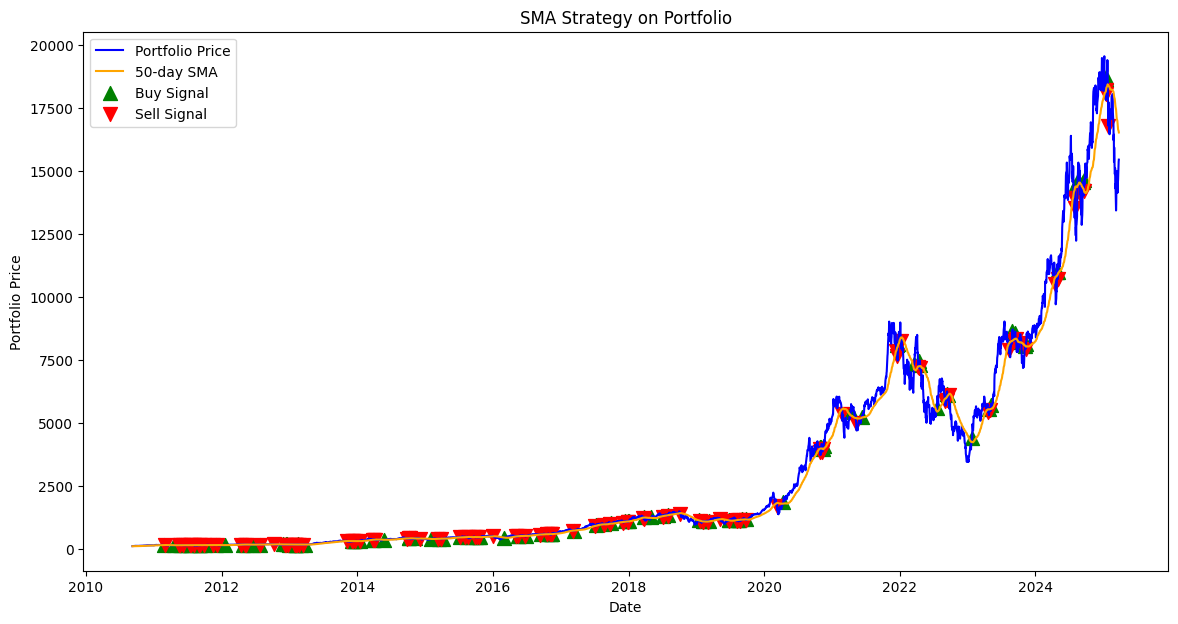

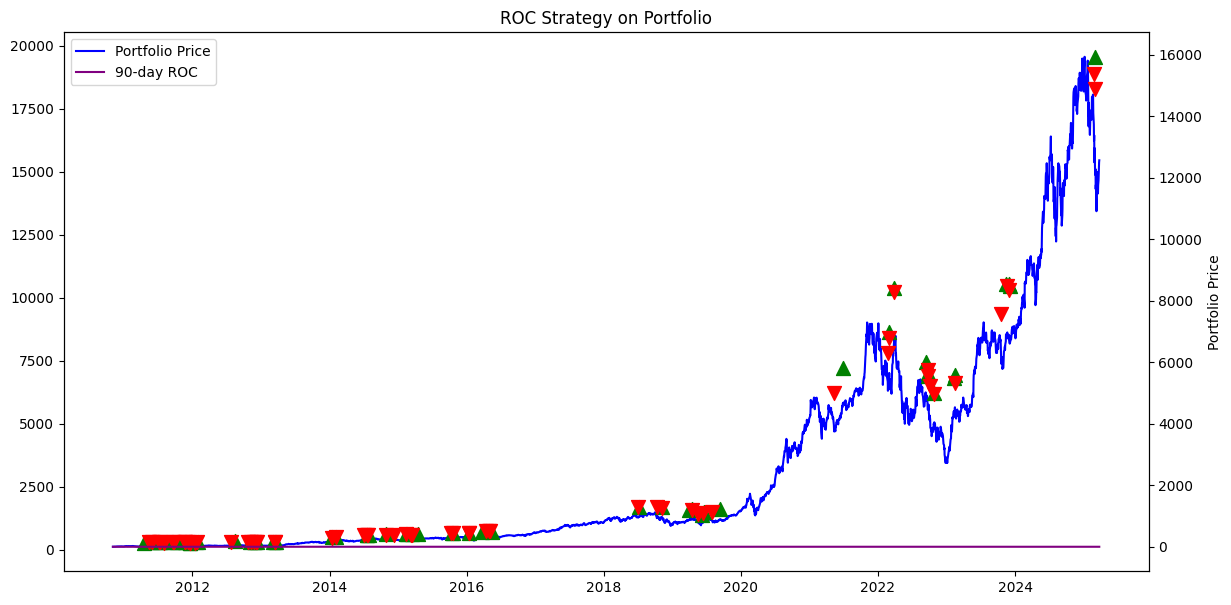

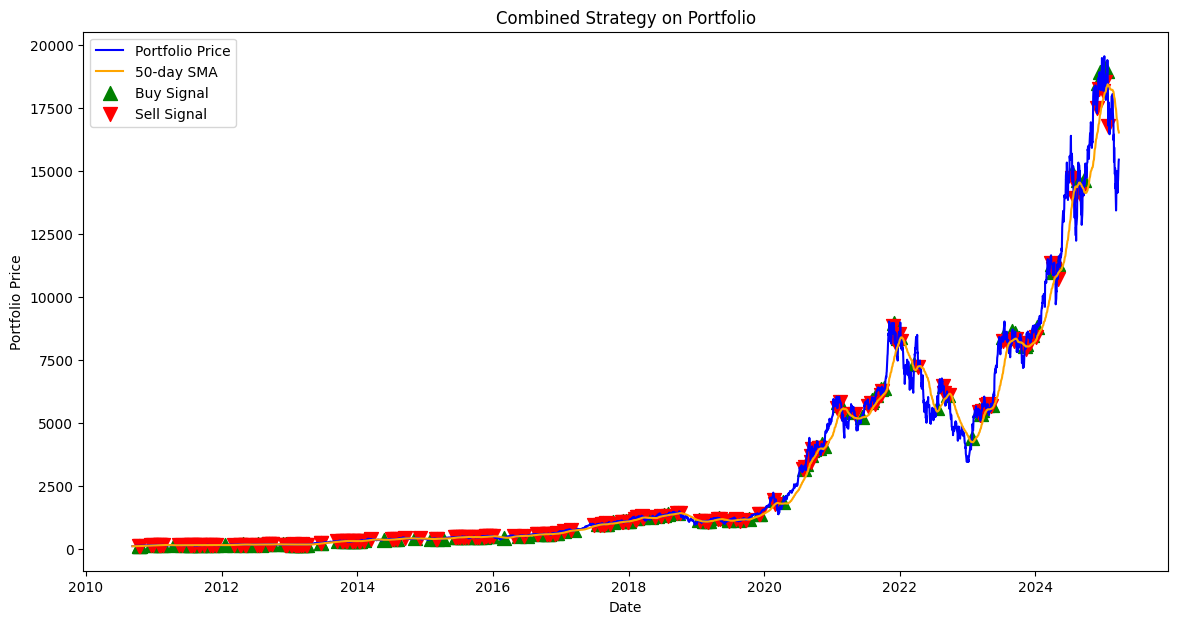

In [ ]:
tickers3 = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'TSLA']
start_date = '2010-01-01'
end_date = '2025-03-26'

raw_data = yf.download(tickers3, start=start_date, end=end_date)

price_df = pd.DataFrame()
for ticker in tickers3:
    try:
        df_ticker = raw_data.xs(ticker, level=1, axis=1).copy()
        price_df[ticker] = df_ticker['Close']
    except KeyError:
        print(f"Ticker {ticker} not found. Skipping.")

price_df.dropna(inplace=True)
normalized = price_df.div(price_df.iloc[0])
portfolio_series = normalized.mean(axis=1) * 100
df_portfolio = pd.DataFrame({'Close': portfolio_series})
df_portfolio.sort_index(inplace=True)

def compute_RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def sma_strategy(df):
    """
    50-day SMA Crossover strategy:
      - Signal = 1 if Close > 50-day SMA, else 0.
    """
    df = df.copy()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df.dropna(subset=['Close', 'SMA_50'], inplace=True)
    df['Signal'] = np.where(df['Close'] > df['SMA_50'], 1, 0)
    return df

def roc_strategy(df):
    """
    90-day Rate of Change (ROC) strategy:
      - Signal = 1 if 90-day ROC > 0, else 0.
    """
    df = df.copy()
    df['ROC_90'] = df['Close'].pct_change(periods=90)
    df.dropna(subset=['Close', 'ROC_90'], inplace=True)
    df['Signal'] = np.where(df['ROC_90'] > 0, 1, 0)
    return df

def combined_strategy(df):
    """
    Combined strategy:
      - Signal = 1 if (Close > 50-day SMA) AND (RSI_14 > 50), else 0.
    """
    df = df.copy()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['RSI_14'] = compute_RSI(df['Close'], period=14)
    df.dropna(subset=['Close', 'SMA_50', 'RSI_14'], inplace=True)
    df['Signal'] = np.where((df['Close'] > df['SMA_50']) & (df['RSI_14'] > 50), 1, 0)
    return df

def backtest_strategy(df):
    """
    Backtests a strategy using a 'Signal' column.
    Returns:
      - DataFrame with strategy and buy-and-hold returns.
      - Dictionary of performance metrics.
      - DataFrame of trade details.
    """
    df = df.copy()
    df['Return'] = df['Close'].pct_change()
    df['Strategy_Return'] = df['Signal'].shift(1) * df['Return']
    df['Strategy_Cum'] = (1 + df['Strategy_Return']).cumprod()
    df['BuyHold_Cum'] = (1 + df['Return']).cumprod()
    
    daily_sr = df['Strategy_Return'].dropna()
    sharpe = (daily_sr.mean() / daily_sr.std()) * np.sqrt(252) if daily_sr.std() != 0 else 0
    cumulative_return = df['Strategy_Cum'].iloc[-1] - 1
    buy_hold_return = df['BuyHold_Cum'].iloc[-1] - 1

    running_max = df['Strategy_Cum'].cummax()
    drawdown = (df['Strategy_Cum'] - running_max) / running_max
    max_drawdown = drawdown.min()

    in_position = False
    trades = []
    entry_price, entry_date = None, None
    for i in range(1, len(df)):
        prev_signal = df['Signal'].iloc[i - 1]
        curr_signal = df['Signal'].iloc[i]
        curr_date = df.index[i]
        curr_close = df['Close'].iloc[i]
        if not in_position and prev_signal == 0 and curr_signal == 1:
            in_position = True
            entry_price = curr_close
            entry_date = curr_date
        elif in_position and prev_signal == 1 and curr_signal == 0:
            exit_price = curr_close
            exit_date = curr_date
            trade_return = (exit_price / entry_price) - 1
            trades.append({
                'Entry_Date': entry_date,
                'Exit_Date': exit_date,
                'Entry_Price': entry_price,
                'Exit_Price': exit_price,
                'Return': trade_return
            })
            in_position = False
    if in_position:
        exit_price = df['Close'].iloc[-1]
        exit_date = df.index[-1]
        trade_return = (exit_price / entry_price) - 1
        trades.append({
            'Entry_Date': entry_date,
            'Exit_Date': exit_date,
            'Entry_Price': entry_price,
            'Exit_Price': exit_price,
            'Return': trade_return
        })
    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        avg_win = trades_df[trades_df['Return'] > 0]['Return'].mean()
        avg_loss = trades_df[trades_df['Return'] <= 0]['Return'].mean()
    else:
        avg_win, avg_loss = 0, 0

    metrics = {
        'Sharpe Ratio': sharpe,
        'Cumulative Return': cumulative_return,
        'Buy and Hold Return': buy_hold_return,
        'Max Drawdown': max_drawdown,
        'Average Win': avg_win,
        'Average Loss': avg_loss,
        'Number of Trades': len(trades_df)
    }
    return df, metrics, trades_df

strategies = {
    'SMA': sma_strategy,
    'ROC': roc_strategy,
    'Combined': combined_strategy
}
results = {}

for strat_name, strat_func in strategies.items():
    df_strat = strat_func(df_portfolio)
    if df_strat.empty:
        continue
    df_backtest, metrics, trades_df = backtest_strategy(df_strat)
    results[strat_name] = {
        'df': df_backtest,
        'metrics': metrics,
        'trades': trades_df
    }
    print(f"\n{strat_name} Strategy Results")
    for k, v in metrics.items():
        print(f"{k}: {v}")

for strat_name, result in results.items():
    df_plot = result['df']
    trades_df = result['trades']
    
    plt.figure(figsize=(14, 7))
    plt.plot(df_plot.index, df_plot['Close'], label='Portfolio Price', color='blue', linewidth=1.5)
    
    if strat_name in ['SMA', 'Combined']:
        if 'SMA_50' in df_plot.columns:
            plt.plot(df_plot.index, df_plot['SMA_50'], label='50-day SMA', color='orange', linewidth=1.5)
    elif strat_name == 'ROC':
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        ax2.plot(df_plot.index, df_plot['ROC_90'], label='90-day ROC', color='purple', linewidth=1.5)
        ax2.set_ylabel("90-day ROC")
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper left')
    if not trades_df.empty:
        plt.scatter(trades_df['Entry_Date'], trades_df['Entry_Price'], marker='^', color='green', s=100, label='Buy Signal')
        plt.scatter(trades_df['Exit_Date'], trades_df['Exit_Price'], marker='v', color='red', s=100, label='Sell Signal')
    
    plt.title(f"{strat_name} Strategy on Portfolio")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Price")
    if strat_name != 'ROC':
        plt.legend()
    plt.show()


## 3.3.4:

### Comparison with buy-and-hold

**SMA Strategy:**  
- **Cumulative Return:** The SMA strategy delivered a cumulative return of about 38.5% versus a 147.6% return for buy‐and‐hold—capturing roughly 26% of the market’s gain.  
- **Risk-Adjusted Performance:** With a Sharpe ratio of 1.12, the SMA strategy shows efficient risk compensation relative to its lower return, and its max drawdown of about –26.7% suggests it limits downside risk compared to a full market exposure.  
- **Trading Frequency:** Executing 109 trades indicates a moderate level of market timing that sacrifices some upside capture for reduced volatility.

**ROC Strategy:**  
- **Cumulative Return:** The ROC strategy achieved a cumulative return of roughly 29.4% against a 123.7% buy‐and‐hold return, indicating even lower participation in the market’s full upward trend.  
- **Risk-Adjusted Performance:** Its Sharpe ratio of 0.95, combined with a higher max drawdown of –48.8%, implies that while returns are generated, the strategy is exposed to larger losses during downturns.  
- **Trading Frequency:** Fewer trades (60) suggest a less active approach, which may reduce trading costs but can also limit responsiveness to market shifts.

**Combined Strategy:**  
- **Cumulative Return:** The Combined strategy produced the lowest cumulative return at about 18.6%, compared to 147.6% for buy‐and‐hold, meaning it participates in only a small portion of the market’s gains.  
- **Risk-Adjusted Performance:** A Sharpe ratio of 1.01 and a max drawdown of –37.2% indicate moderate risk management; however, the more aggressive entry criteria (requiring both a 50-day SMA and RSI above 50) reduce overall market exposure.  
- **Trading Frequency:** With 189 trades, the higher activity reflects frequent adjustments that may filter out some risk but also result in missing much of the market’s sustained uptrend.

Overall, while all three strategies offer different degrees of risk control (as evidenced by their drawdowns and Sharpe ratios), they all underperform buy‐and‐hold in terms of cumulative return—highlighting the classic tradeoff between active timing and capturing the full market return.

In [6]:
def get_data(tickers, start_date, end_date):
    """
    Downloads daily close prices for the specified tickers and returns a DataFrame.
    Assumes yfinance returns a MultiIndex DataFrame; we extract the 'Close' prices.
    """
    raw_data = yf.download(tickers, start=start_date, end=end_date)
    price_df = pd.DataFrame()
    for ticker in tickers:
        df_ticker = raw_data.xs(ticker, level=1, axis=1).copy()
        price_df[ticker] = df_ticker['Close']
    price_df.dropna(inplace=True)
    return price_df

def backtest_pair(spread, entry_z=1.0, exit_z=0.0):
    """
    Backtests a simple mean-reversion trade on the spread:
      - Compute overall mean and std of the spread.
      - Generate a position (signal) when the z-score exceeds entry_z in either direction.
      - Exit the position when the z-score crosses exit_z (assumed to be zero).
      
    Returns:
      - daily_return: The daily return series of the trade.
      - cum_return: The cumulative return series.
      - signal: The generated position series.
      - zscore: The z-score series of the spread.
    """
    mean_spread = spread.mean()
    std_spread = spread.std()
    zscore = (spread - mean_spread) / std_spread

    signal = pd.Series(0, index=spread.index)
    position = 0
    for t in range(1, len(zscore)):
        if position == 0:
            if zscore.iloc[t] > entry_z:
                position = -1
            elif zscore.iloc[t] < -entry_z:
                position = 1 
        else:
            if (position == 1 and zscore.iloc[t] >= exit_z) or (position == -1 and zscore.iloc[t] <= exit_z):
                position = 0
        signal.iloc[t] = position
    
    daily_return = signal.shift(1) * (spread.diff() / std_spread)
    daily_return.fillna(0, inplace=True)
    cum_return = (1 + daily_return).cumprod() - 1
    return daily_return, cum_return, signal, zscore

def aggregate_performance(daily_returns):
    """
    Given a list of daily return Series from each pair, compute the equally weighted portfolio.
    Returns portfolio daily return, cumulative return, Sharpe ratio, and maximum drawdown.
    """
    df = pd.concat(daily_returns, axis=1)
    portfolio_return = df.mean(axis=1)
    cum_return = (1 + portfolio_return).cumprod() - 1
    sharpe = portfolio_return.mean() / portfolio_return.std() * np.sqrt(252) if portfolio_return.std() != 0 else 0
    running_max = (1 + portfolio_return).cummax()
    drawdown = ((1 + portfolio_return) / running_max) - 1
    max_drawdown = drawdown.min()
    return portfolio_return, cum_return, sharpe, max_drawdown


def correlation_based_pairs(tickers, start_date, end_date, corr_threshold=0.8, entry_z=1.0, exit_z=0.0):
    """
    Implements a pairs trading strategy based on high correlation.
    
    Assumptions:
      - Candidate pairs are selected if the Pearson correlation between the log price series 
        is above corr_threshold.
      - For each pair, the spread is computed as: spread = log(price1) - log(price2)
      - Trade signals are generated when the spread's z-score exceeds entry_z.
      - Positions are exited when the z-score crosses zero.
      - No transaction costs; positions are equally weighted.
    """
    price_df = get_data(tickers, start_date, end_date)
    norm_prices = np.log(price_df)
    candidate_pairs = []
    for pair in itertools.combinations(tickers, 2):
        corr = norm_prices[pair[0]].corr(norm_prices[pair[1]])
        if corr >= corr_threshold:
            candidate_pairs.append(pair)
    print("Correlation-based pairs selected:", candidate_pairs)
    
    pair_returns = []
    for (ticker1, ticker2) in candidate_pairs:
        spread = norm_prices[ticker1] - norm_prices[ticker2]
        daily_ret, cum_ret, signal, zscore = backtest_pair(spread, entry_z, exit_z)
        pair_returns.append(daily_ret)
    if pair_returns:
        port_return, port_cum, port_sharpe, port_dd = aggregate_performance(pair_returns)
    else:
        port_return, port_cum, port_sharpe, port_dd = None, None, None, None
        
    return {
        "pairs": candidate_pairs,
        "portfolio_daily_return": port_return,
        "portfolio_cumulative_return": port_cum,
        "portfolio_sharpe": port_sharpe,
        "portfolio_max_drawdown": port_dd
    }

def cointegration_based_pairs(tickers, start_date, end_date, pvalue_threshold=0.1, entry_z=1.0, exit_z=0.0):
    """
    Implements a pairs trading strategy based on cointegration.
    
    Assumptions:
      - Uses the Engle–Granger cointegration test and selects pairs with p-value < pvalue_threshold.
      - The hedge ratio is estimated via OLS regression of log(price1) on log(price2).
      - The spread is defined as: spread = log(price1) - (hedge_ratio * log(price2))
      - Trade signals are generated when the spread's z-score deviates by more than entry_z.
      - Positions are closed when the z-score reverts to 0.
      - No transaction costs; pairs are equally weighted.
    """
    price_df = get_data(tickers, start_date, end_date)
    norm_prices = np.log(price_df)
    candidate_pairs = []
    pair_returns = []
    for pair in itertools.combinations(tickers, 2):
        series1 = norm_prices[pair[0]]
        series2 = norm_prices[pair[1]]
        score, pvalue, _ = coint(series1, series2)
        if pvalue < pvalue_threshold:
            candidate_pairs.append(pair)
            model = sm.OLS(series1, sm.add_constant(series2)).fit()
            hedge_ratio = model.params[1]
            spread = series1 - hedge_ratio * series2
            daily_ret, cum_ret, signal, zscore = backtest_pair(spread, entry_z, exit_z)
            pair_returns.append(daily_ret)
    print("Cointegration-based pairs selected:", candidate_pairs)
    if pair_returns:
        port_return, port_cum, port_sharpe, port_dd = aggregate_performance(pair_returns)
    else:
        port_return, port_cum, port_sharpe, port_dd = None, None, None, None
    return {
        "pairs": candidate_pairs,
        "portfolio_daily_return": port_return,
        "portfolio_cumulative_return": port_cum,
        "portfolio_sharpe": port_sharpe,
        "portfolio_max_drawdown": port_dd
    }

def distance_based_pairs(tickers, start_date, end_date, top_n=None, entry_z=1.0, exit_z=0.0):
    """
    Implements a pairs trading strategy based on the distance between normalized log price series.
    
    Assumptions:
      - Normalize log prices by subtracting the initial value.
      - Compute the Euclidean distance between each pair’s normalized series.
      - Select pairs with the smallest distances. If top_n is not provided, the bottom 50% (by distance) are chosen.
      - For each selected pair, the spread is defined as the difference of the normalized log prices.
      - Trade signals are generated when the spread’s z-score deviates by more than entry_z.
      - Positions are exited when the z-score crosses zero.
      - No transaction costs; pairs are equally weighted.
    """
    price_df = get_data(tickers, start_date, end_date)
    norm_prices = np.log(price_df)
    norm_prices = norm_prices.apply(lambda x: x - x.iloc[0])
    pair_distance = []
    for pair in itertools.combinations(tickers, 2):
        dist = np.linalg.norm(norm_prices[pair[0]] - norm_prices[pair[1]])
        pair_distance.append((pair, dist))
    pair_distance.sort(key=lambda x: x[1])
    if top_n is None:
        top_n = len(pair_distance) // 2
    selected_pairs = [pair for pair, dist in pair_distance[:top_n]]
    print("Distance-based pairs selected:", selected_pairs)
    
    pair_returns = []
    for (ticker1, ticker2) in selected_pairs:
        spread = norm_prices[ticker1] - norm_prices[ticker2]
        daily_ret, cum_ret, signal, zscore = backtest_pair(spread, entry_z, exit_z)
        pair_returns.append(daily_ret)
    if pair_returns:
        port_return, port_cum, port_sharpe, port_dd = aggregate_performance(pair_returns)
    else:
        port_return, port_cum, port_sharpe, port_dd = None, None, None, None
    return {
        "pairs": selected_pairs,
        "portfolio_daily_return": port_return,
        "portfolio_cumulative_return": port_cum,
        "portfolio_sharpe": port_sharpe,
        "portfolio_max_drawdown": port_dd
    }


    # For simplicity, assume the pair's daily return is proportional to the change in spread
    # scaled by the signal. (This is a simplified backtest.)

In [ ]:
# picked 5 banks for example portfolio
start_date = '2010-01-01'
end_date = '2025-03-26'
tickers = ['JPM', 'BAC', 'C', 'WFC', 'GS']

print("Correlation-Based Pairs Trading")
corr_results = correlation_based_pairs(tickers, start_date, end_date)
print(corr_results)

print("\nCointegration-Based Pairs Trading")
coint_results = cointegration_based_pairs(tickers, start_date, end_date)
print(coint_results)

print("\nDistance-Based Pairs Trading")
dist_results = distance_based_pairs(tickers, start_date, end_date)
print(dist_results)

Correlation-Based Pairs Trading
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


Correlation-based pairs selected: [('JPM', 'BAC'), ('JPM', 'C'), ('JPM', 'GS'), ('BAC', 'C'), ('BAC', 'GS'), ('C', 'WFC'), ('C', 'GS')]


[*********************100%***********************]  5 of 5 completed

{'pairs': [('JPM', 'BAC'), ('JPM', 'C'), ('JPM', 'GS'), ('BAC', 'C'), ('BAC', 'GS'), ('C', 'WFC'), ('C', 'GS')], 'portfolio_daily_return': Date
2010-01-04    0.000000
2010-01-05    0.000000
2010-01-06    0.005039
2010-01-07   -0.009259
2010-01-08    0.014557
                ...   
2025-03-19   -0.004050
2025-03-20    0.014151
2025-03-21   -0.016547
2025-03-24   -0.006691
2025-03-25   -0.009754
Length: 3830, dtype: float64, 'portfolio_cumulative_return': Date
2010-01-04    0.000000
2010-01-05    0.000000
2010-01-06    0.005039
2010-01-07   -0.004267
2010-01-08    0.010228
                ...   
2025-03-19    8.856732
2025-03-20    8.996212
2025-03-21    8.830802
2025-03-24    8.765022
2025-03-25    8.669777
Length: 3830, dtype: float64, 'portfolio_sharpe': 0.6350287685990643, 'portfolio_max_drawdown': -0.226726625196492}

Cointegration-Based Pairs Trading



/var/folders/kl/99r23_5x5x5ggl9nb8wl5wtc0000gn/T/ipykernel_41362/810146989.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]


Cointegration-based pairs selected: [('BAC', 'C')]
{'pairs': [('BAC', 'C')], 'portfolio_daily_return': Date
2010-01-04    0.000000
2010-01-05    0.000000
2010-01-06    0.166684
2010-01-07   -0.111567
2010-01-08   -0.079545
                ...   
2025-03-19   -0.066109
2025-03-20   -0.011239
2025-03-21   -0.016446
2025-03-24   -0.139944
2025-03-25   -0.020719
Length: 3830, dtype: float64, 'portfolio_cumulative_return': Date
2010-01-04    0.000000
2010-01-05    0.000000
2010-01-06    0.166684
2010-01-07    0.036520
2010-01-08   -0.045930
                ...   
2025-03-19    5.346786
2025-03-20    5.275453
2025-03-21    5.172250
2025-03-24    4.308483
2025-03-25    4.198498
Length: 3830, dtype: float64, 'portfolio_sharpe': 0.707983521293028, 'portfolio_max_drawdown': -0.8860301702535196}

Distance-Based Pairs Trading


[*********************100%***********************]  5 of 5 completed


Distance-based pairs selected: [('BAC', 'GS'), ('C', 'WFC'), ('C', 'GS'), ('BAC', 'C'), ('WFC', 'GS')]
{'pairs': [('BAC', 'GS'), ('C', 'WFC'), ('C', 'GS'), ('BAC', 'C'), ('WFC', 'GS')], 'portfolio_daily_return': Date
2010-01-04    0.000000
2010-01-05    0.000000
2010-01-06    0.000000
2010-01-07    0.000000
2010-01-08    0.000000
                ...   
2025-03-19    0.013019
2025-03-20   -0.006241
2025-03-21   -0.005010
2025-03-24    0.001041
2025-03-25   -0.007773
Length: 3830, dtype: float64, 'portfolio_cumulative_return': Date
2010-01-04    0.000000
2010-01-05    0.000000
2010-01-06    0.000000
2010-01-07    0.000000
2010-01-08    0.000000
                ...   
2025-03-19    7.011436
2025-03-20    6.961437
2025-03-21    6.921548
2025-03-24    6.929791
2025-03-25    6.868153
Length: 3830, dtype: float64, 'portfolio_sharpe': 0.5650871032731324, 'portfolio_max_drawdown': -0.23800214585380508}
